### Fraud Detection

#### Module Imports

In [1]:
import pandas as pd
pd.set_option('display.float_format', lambda x: f"{x}") #set pandas to display floats as strings  to avoid e notations and truncations
pd.set_option('display.max_colwidth', None) #Removing truncations
import numpy as np

from category_encoders import HashingEncoder
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, BisectingKMeans
from sklearn.metrics import silhouette_score

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import IsolationForest
import joblib

import warnings
warnings.filterwarnings('ignore')



#### Data Import

In [2]:
df = pd.read_csv('Final_data.csv')
df.head(1)

,AILMENT,BENEFIT,DATE_OF_BIRTH,AGE,GENDER,RELATIONSHIP,AILMENT_DATE,DAYS_SINCE_LAST_VISIT,DAY_OF_MONTH_VISITED,MONTH_VISITED,...,PROVIDER,MEMBER_SUDDO,MAIN_MEMBER_GENDER,MAIN_MEMBER_DOB,MAIN_MEMBER_AGE,CLAIMANT_SUDDO,BROAD_BENEFIT,COVER_LIMIT,FREQUENCY_OF_VISIT,TOTAL_PAYABLE
0,PSEUDOPHAKIA,OUT-PATIENT,26/11/1983,41,M,SELF,08/04/2025,-1,8,4,...,REIMB,0.585528337,M,26/11/1983,41,2.96830421,OUT-PATIENT,300000,3,33000.0


In [3]:
#converting the columns with dates to datetime
df['DATE_OF_BIRTH'] =pd.to_datetime(df['DATE_OF_BIRTH'], dayfirst=True, errors='coerce')
df['AILMENT_DATE'] =pd.to_datetime(df['AILMENT_DATE'], dayfirst=True, errors='coerce')
df['MAIN_MEMBER_DOB'] = pd.to_datetime(df['MAIN_MEMBER_DOB'],dayfirst=True, errors='coerce')
date_cols = df[['DATE_OF_BIRTH','AILMENT_DATE','MAIN_MEMBER_DOB']]

In [4]:
print("No of rows: ", df.shape[0])
print("No of coulums: ", df.shape[1])

No of rows:  88883
No of coulums:  21


Checking for null values in the dataset

In [5]:
empty_records = df.isnull().sum().sum()
if  empty_records > 0:
    df.dropna(inplace=True)
    msg = f"Success: {empty_records} Null records removed"
else:
    msg = "No null records found"
    
print(msg)
print(f"Shape: {df.shape}")

No null records found
Shape: (88883, 21)


In [6]:
df.describe()

,DATE_OF_BIRTH,AGE,AILMENT_DATE,DAYS_SINCE_LAST_VISIT,DAY_OF_MONTH_VISITED,MONTH_VISITED,YEAR_VISITED,MEMBER_SUDDO,MAIN_MEMBER_DOB,MAIN_MEMBER_AGE,CLAIMANT_SUDDO,COVER_LIMIT,FREQUENCY_OF_VISIT,TOTAL_PAYABLE
count,88883,88883.0,88883,88883.0,88883.0,88883.0,88883.0,88883.0,88883,88883.0,88883.0,88883.0,88883.0,88883.0
mean,1994-12-10 09:33:57.325472768,30.07449118504101,2024-01-19 05:49:53.674831104,48.55173655254661,15.63906483804552,6.460943037476233,2023.5554718000067,0.5089766438790096,1987-10-15 16:31:49.782523008,37.22942519941946,1.5006344516950938,229437.95785470787,15.407817017877434,9045.402819184772
min,1943-02-15 00:00:00,0.0,2022-05-18 00:00:00,-1.0,1.0,1.0,2022.0,0.000211771,1949-03-01 00:00:00,0.0,6.38e-05,-1.0,1.0,0.0
25%,1982-01-01 00:00:00,13.0,2023-06-02 00:00:00,2.0,8.0,3.0,2023.0,0.257026931,1978-11-07 00:00:00,32.0,0.754709003,75000.0,7.0,2890.0
50%,1991-04-09 00:00:00,34.0,2024-02-09 00:00:00,18.0,16.0,6.0,2024.0,0.513720337,1986-06-07 00:00:00,39.0,1.508907662,120000.0,13.0,4850.0
75%,2012-05-23 00:00:00,43.0,2024-09-14 00:00:00,56.0,23.0,10.0,2024.0,0.753597651,1992-11-08 00:00:00,46.0,2.239642923,150000.0,20.0,8500.0
max,2025-04-13 00:00:00,82.0,2025-05-28 00:00:00,935.0,31.0,12.0,2025.0,0.999880433,2025-02-12 00:00:00,76.0,2.99977775,10000000.0,113.0,3453578.0
std,NaN,17.096094703357853,NaN,81.40699294026268,8.748367966085677,3.639258443404729,0.8263894039862077,0.28673929737999415,NaN,13.495119181716607,0.8643852816113323,427741.2682328391,12.169075580927156,26462.299325008305


checking max claim details

In [7]:
df[ df['TOTAL_PAYABLE'] == df['TOTAL_PAYABLE'].max()] 

,AILMENT,BENEFIT,DATE_OF_BIRTH,AGE,GENDER,RELATIONSHIP,AILMENT_DATE,DAYS_SINCE_LAST_VISIT,DAY_OF_MONTH_VISITED,MONTH_VISITED,...,PROVIDER,MEMBER_SUDDO,MAIN_MEMBER_GENDER,MAIN_MEMBER_DOB,MAIN_MEMBER_AGE,CLAIMANT_SUDDO,BROAD_BENEFIT,COVER_LIMIT,FREQUENCY_OF_VISIT,TOTAL_PAYABLE
21629,SEPSIS,IN-PATIENT,1998-02-03,27,F,SELF,2025-01-02,-1,2,1,...,THE MATER HOSPITAL,0.633968714,F,1998-02-03,27,0.162561802,IN-PATIENT,-1,1,3453578.0


In [8]:
df[df['CLAIMANT_SUDDO'] == 0.162561802]

,AILMENT,BENEFIT,DATE_OF_BIRTH,AGE,GENDER,RELATIONSHIP,AILMENT_DATE,DAYS_SINCE_LAST_VISIT,DAY_OF_MONTH_VISITED,MONTH_VISITED,...,PROVIDER,MEMBER_SUDDO,MAIN_MEMBER_GENDER,MAIN_MEMBER_DOB,MAIN_MEMBER_AGE,CLAIMANT_SUDDO,BROAD_BENEFIT,COVER_LIMIT,FREQUENCY_OF_VISIT,TOTAL_PAYABLE
21629,SEPSIS,IN-PATIENT,1998-02-03,27,F,SELF,2025-01-02,-1,2,1,...,THE MATER HOSPITAL,0.633968714,F,1998-02-03,27,0.162561802,IN-PATIENT,-1,1,3453578.0


##### Diagnosis field

In [9]:
ailments = df['AILMENT'].unique()
print(len(ailments), "Ailments")

938 Ailments


In [10]:
top_10_ailments = df['AILMENT'].value_counts().head(10)
print(top_10_ailments)

AILMENT
PHARYNGITIS                          7856
TONSILLITIS                          3281
A.N.C. CLINIC                        2767
GASTRITIS                            2738
GASTRO ENTERITIS                     2665
DENTAL CARIES                        2548
HYPERTENSION                         2340
URINARY TRACT INFECTION              2160
RHINITIS                             2126
UPPER RESPIRATORY TRACT INFECTION    1590
Name: count, dtype: int64


In [11]:
bottom_10_ailments = df['AILMENT'].value_counts().tail(10)
print(bottom_10_ailments)

AILMENT
SKIN SEPSIS                1
LETHARGY                   1
ARRYTHMIA                  1
DISPLASIA                  1
SPINE STENOSIS             1
URETERIC STONE             1
REACTIONARY ILLNESS        1
POSTDATISM                 1
IMMUNOGLOBIN DEFICIENCY    1
ODYNOPHAGIA                1
Name: count, dtype: int64


#### Providers

In [12]:
providers = len(df['PROVIDER'].unique())
print(providers, "providers")

780 providers


In [13]:
top_10_providers = df['PROVIDER'].value_counts().head(10)
print(top_10_providers.to_string())

PROVIDER
EQUITY AFIA                             13876
AVENUE HEALTHCARE                        7610
AAR HEALTH SERVICES                      5217
GERTRUDE'S GARDEN CHILDRENS HOSPITAL     3691
AGA KHAN HOSPITAL NAIROBI                3556
PENDA HEALTH LIMITED                     2044
NAIROBI HOSPITAL                         2021
METROPOLITAN HOSPITAL LTD                1926
KOMAROCK MODERN PATIENTS CARE CENTRE     1905
AGA KHAN HOSPITAL MOMBASA                1677


In [14]:
bottom_10_providers = df['PROVIDER'].value_counts().tail(10)
print(bottom_10_providers.to_string())

PROVIDER
UPPERHILL INSTITUTE OF PAEDIATRICS & ENT CENTRE - 0    1
DR. GEORGE FANUEL JUMBA                                1
AMREF MEDICAL CENTRE                                   1
WEST SIDE DENTAL PRACTICE                              1
CANCER CARE KENYA                                      1
MARY HELP OF THE SICK MISSION HOSPITAL                 1
RUBY SMILES DENTAL CLINIC                              1
EUREKA LOKI MEDICAL CLINIC                             1
VICTORIA HOSPITAL KAMPALA - 0                          1
EYE TECH LTD.                                          1


#### Benefit

In [15]:
uniques= df['BENEFIT'].unique()
print(len(uniques), "Benefits")
uniques

31 Benefits


array(['OUT-PATIENT', 'IP OPTICAL NON ACCIDENTAL', 'DENTAL / OPTICAL',
       'OPTICAL', 'MATERNITY', 'DENTAL', 'IN-PATIENT',
       'INPATIENT OPTICAL', 'IP PRE-EXISTING & CHRONIC',
       'HEALTH CHECK UPS', 'IN-OUT PATIENT', 'SCALING/POLISHING',
       'CONGENITAL CONDITIONS', 'LAST EXPENSE', 'VACCINATIONS',
       'IP DENTAL NON ACCIDENTAL', 'MATERNITY C- SECTION',
       'CHRONIC AILMENTS', 'IP ILLNESS DENTAL', 'IP OPTICAL ACCIDENTAL',
       'PRE-NATAL & ITS COMPLICATIONS', 'FAMILY PLANNING',
       'IP ILLNESS OPTICAL', 'CONGENITAL & PREMATURITY', 'IP DENTAL',
       'ANTE-NATAL & POST-NATAL CLINIC', 'PROPHYLAXIS',
       'IP DENTAL ACCIDENTAL', 'CIRCUMCISION', 'INPATIENT PSYCHIATRY',
       'POST HOSPITALISATION'], dtype=object)

#### Broad Benefits

In [16]:
uniques = df['BROAD_BENEFIT'].unique()
print(len(uniques),"Broad Benefits")
uniques

9 Broad Benefits


array(['OUT-PATIENT', 'IN-PATIENT', 'OPTICAL', 'MATERNITY', 'DENTAL',
       'Optical', 'LAST EXPENSE', 'Dental', 'Maternity'], dtype=object)

#### Feature engineering

In [17]:
#calculating average columns and deviations from means for the categorical columns

#By ailment alone

df['ailment_alone_mean'] = df.groupby('AILMENT')['TOTAL_PAYABLE'].transform('mean') #benefit grouping mean
df['ailment_alone_mean_dev'] = df['TOTAL_PAYABLE']-df['ailment_alone_mean'] #Deviation from mean by benefit grouping
df['pct_ailment_alone_mean_dev'] = (df['ailment_alone_mean_dev']/df['ailment_alone_mean']) * 100 #percentage deviation from benefit mean

#By provider alone
df['provider_alone_mean'] = df.groupby('PROVIDER')['TOTAL_PAYABLE'].transform('mean')
df['provider_alone_mean_dev'] = df['TOTAL_PAYABLE'] - df['provider_alone_mean']
df['pct_provider_alone_mean_dev'] = (df['provider_alone_mean_dev']/df['provider_alone_mean']) * 100 #percentage deviation from ailment mean

#By benefit alone
df['benefit_alone_mean'] = df.groupby('BENEFIT')['TOTAL_PAYABLE'].transform('mean')
df['benefit_alone_mean_dev'] = df['TOTAL_PAYABLE'] - df['benefit_alone_mean']
df['pct_benefit_alone_mean_dev'] = (df['benefit_alone_mean_dev']/df['benefit_alone_mean']) * 100 #percentage deviation from ailment mean

#By broad_benefit alone
df['broad_benefit_alone_mean'] = df.groupby('BROAD_BENEFIT')['TOTAL_PAYABLE'].transform('mean')
df['broad_benefit_alone_mean_dev'] = df['TOTAL_PAYABLE'] - df['broad_benefit_alone_mean']
df['broad_benefit_alone_ailment_mean_dev'] = (df['broad_benefit_alone_mean_dev']/df['broad_benefit_alone_mean']) * 100 #percentage deviation from ailment mean

#By diagnosis
df['ailment_mean'] = df.groupby(['PROVIDER','AILMENT'])['TOTAL_PAYABLE'].transform('mean')
df['ailment_mean_dev'] = df['TOTAL_PAYABLE'] - df['ailment_mean']
df['pct_ailment_mean_dev'] = (df['ailment_mean_dev']/df['ailment_mean']) * 100 #percentage deviation from ailment mean

#By Provider
df['provider_mean'] = df.groupby(['PROVIDER','BENEFIT'])['TOTAL_PAYABLE'].transform('mean')
df['provider_mean_dev'] = df['TOTAL_PAYABLE'] - df['provider_mean']
df['pct_provider_mean_dev'] = (df['provider_mean_dev']/df['provider_mean']) * 100 #percentage deviation from provider

#By Broad Benefit
df['broad_benefit_mean']= df.groupby(['BROAD_BENEFIT','BENEFIT'])['TOTAL_PAYABLE'].transform('mean')
df['broad_benefit_mean_dev'] = df['TOTAL_PAYABLE'] - df['broad_benefit_mean']
df['pct_broad_benefit_mean_dev'] = (df['broad_benefit_mean_dev']/df['broad_benefit_mean']) * 100 #percentage deviation from broad benefit mean

#By Relationship
df['relationship_mean'] = df.groupby('RELATIONSHIP')['TOTAL_PAYABLE'].transform('mean')
df['relationship_mean_dev'] = df['TOTAL_PAYABLE'] - df['relationship_mean']
df['pct_relationship_mean_dev'] = (df['relationship_mean_dev']/df['relationship_mean']) * 100 #percentage deviation from relationship mean

#By gender
df['gender_mean'] = df.groupby(['AILMENT','GENDER'])['TOTAL_PAYABLE'].transform('mean')
df['gender_mean_dev'] = df['TOTAL_PAYABLE'] - df['gender_mean']
df['pct_gender_mean_dev'] = (df['gender_mean_dev']/df['gender_mean']) * 100 #percentage deviation from gender mean

#age is not categorical but I will include it in this
#By age
df['age_mean'] = df.groupby(['AILMENT','AGE'])['TOTAL_PAYABLE'].transform('mean')
df['age_mean_dev'] = df['TOTAL_PAYABLE'] - df['age_mean']
df['pct_age_mean_dev'] = (df['age_mean_dev']/df['age_mean']) * 100 #percentage deviation from age mean

df['claimant_suddo_freq'] = df['CLAIMANT_SUDDO'].map(df['CLAIMANT_SUDDO'].value_counts())
df['main_member_suddo'] = df['MEMBER_SUDDO'].map(df['MEMBER_SUDDO'].value_counts())
df.head(1)

,AILMENT,BENEFIT,DATE_OF_BIRTH,AGE,GENDER,RELATIONSHIP,AILMENT_DATE,DAYS_SINCE_LAST_VISIT,DAY_OF_MONTH_VISITED,MONTH_VISITED,...,relationship_mean_dev,pct_relationship_mean_dev,gender_mean,gender_mean_dev,pct_gender_mean_dev,age_mean,age_mean_dev,pct_age_mean_dev,claimant_suddo_freq,main_member_suddo
0,PSEUDOPHAKIA,OUT-PATIENT,1983-11-26,41,M,SELF,2025-04-08,-1,8,4,...,23752.33149559603,256.8467012445849,54487.0,-21487.0,-39.43509460972342,88861.66666666667,-55861.66666666667,-62.863626985764384,3,3


#### Encoding the Categorical

In [18]:
categorical_columns = df.select_dtypes('object').columns.tolist()
categorical_columns

['AILMENT',
 'BENEFIT',
 'GENDER',
 'RELATIONSHIP',
 'PROVIDER',
 'MAIN_MEMBER_GENDER',
 'BROAD_BENEFIT']

In [19]:
#gender, relationship, broad_benefit, and main_member_gender have low cardinality
# will encode them with one-hot encoding
categorical_low = ['BROAD_BENEFIT', 'GENDER', 'RELATIONSHIP', 'MAIN_MEMBER_GENDER']
categorical_high = list(set(categorical_columns) -set(categorical_low))

#onehotencoding for columns with low cardinality
df_encoded = pd.get_dummies(df,columns = categorical_low, drop_first=False)
#df_encoded = pd.concat([df,dummies],axis=1)

#Frequency Encoding for the categorical columns with high cardinality
for category in categorical_high:
    frequency = df[category].value_counts()
    df_encoded[category + '_freq'] = df[category].map(frequency)

df_encoded.shape

(88883, 70)

In [20]:
#DROP DATE COLUMNS
df_encoded = df_encoded.drop(date_cols, axis=1)

In [21]:
#df['TOTAL_PAYABLE'] = np.log1p(df['TOTAL_PAYABLE']) #price has 0 and 1

In [22]:
# Dropping all the categorical columns
df_encoded = df_encoded.drop(columns=categorical_high)

In [23]:
df_encoded.shape

(88883, 64)

#### Standardizing using Standard Scaler

In [24]:
# Check for infinity
print("Number of +inf values:", np.isinf(df_encoded).sum().sum())
print("Number of -inf values:", np.isneginf(df_encoded).sum().sum())

# Check for NaNs
print("Number of NaNs:", df_encoded.isna().sum().sum())

# Check for extremely large values
print("Max value:", df_encoded.max().max())
print("Min value:", df_encoded.min().min())

Number of +inf values: 0
Number of -inf values: 0
Number of NaNs: 4
Max value: 10000000
Min value: -931794.5


In [25]:
%%time
df_encoded.fillna(0,inplace=True) #filling NAN values with 0
scaler = StandardScaler()
scaled_df= scaler.fit_transform(df_encoded)


CPU times: total: 703 ms
Wall time: 756 ms


In [26]:
"""%%time
pca = PCA(n_components=0.95) #Keeping 95% of the variability
pca_df = pca.fit_transform(scaled_df)
pca_df = pd.DataFrame(pca_df)"""

'%%time\npca = PCA(n_components=0.95) #Keeping 95% of the variability\npca_df = pca.fit_transform(scaled_df)\npca_df = pd.DataFrame(pca_df)'

#### Training BisectingKmeans model and Evaluating using Silhouette score

In [27]:
%%time
#training bisectingkmeans for a range of n_clusters
scores = []
clusters = []

for k in range(2,8):
    model = BisectingKMeans(n_clusters=k, init='k-means++', random_state=42, bisecting_strategy='biggest_inertia')
    labels = model.fit_predict(scaled_df)
    score = silhouette_score(scaled_df, labels)
    scores.append(score)
    clusters.append(k)


CPU times: total: 20min 27s
Wall time: 16min 58s


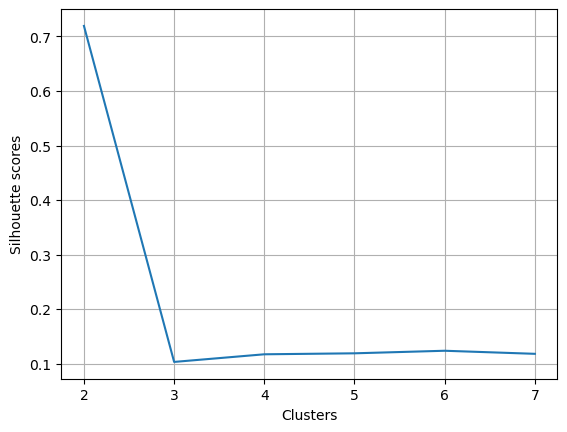

In [28]:

#Plotting the silhouette scores
#plt.figure(figsize(12,4))
plt.plot(clusters,scores)
plt.xlabel('Clusters')
plt.ylabel('Silhouette scores')
plt.grid(True)
plt.show()

#### Training the model

In [29]:
model = KMeans(n_clusters=2, random_state=42)
model.fit(scaled_df)
labels = model.labels_
df['cluster'] = labels

#### Visualizing the clusters

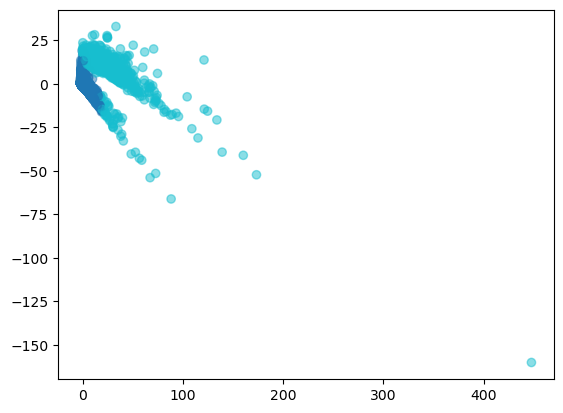

CPU times: total: 3.98 s
Wall time: 4.19 s


In [30]:
%%time
#pca for visualizing
pca_2 = PCA(n_components=2)
df_pca_2 = pca_2.fit_transform(scaled_df)
df_pca_2 = pd.DataFrame(df_pca_2, columns=['PCA1','PCA2'], index = df_encoded.index)
x = df_pca_2['PCA1']
y = df_pca_2['PCA2']
plt.scatter(x,y,c=df['cluster'], cmap='tab10', alpha=0.5)
plt.show()


#### Getting Distance from clusters

In [31]:
print(df.shape)
encoded_columns = [col for col in df_encoded.columns if col not in df.columns]
encoded_columns = df_encoded[encoded_columns]
df = pd.concat([df,encoded_columns], axis=1)
print(df.shape)

(88883, 54)
(88883, 75)


In [32]:
centroids = model.cluster_centers_

#calculating distance of values from the cluster centers using Eucledian distance
df['distance_from_centroid'] = np.linalg.norm(scaled_df - centroids[labels],axis=1)
df.head(1)

,AILMENT,BENEFIT,DATE_OF_BIRTH,AGE,GENDER,RELATIONSHIP,AILMENT_DATE,DAYS_SINCE_LAST_VISIT,DAY_OF_MONTH_VISITED,MONTH_VISITED,...,RELATIONSHIP_SELF,RELATIONSHIP_SPOUSE,MAIN_MEMBER_GENDER_F,MAIN_MEMBER_GENDER_M,MAIN_MEMBER_GENDER_f,MAIN_MEMBER_GENDER_m,AILMENT_freq,BENEFIT_freq,PROVIDER_freq,distance_from_centroid
0,PSEUDOPHAKIA,OUT-PATIENT,1983-11-26,41,M,SELF,2025-04-08,-1,8,4,...,True,False,False,True,False,False,7,76585,1082,13.000056793873974


In [33]:
df['distance_from_centroid'].describe([0.25, 0.50, 0.75,0.90,0.95,0.99])

count              88883.0
mean    5.9669170701795835
std      4.419431150674053
min     2.9726782380962344
25%      4.530189692067662
50%      5.110702434822225
75%      6.234473330683231
90%      7.721197863055026
95%      9.407775888294506
99%      21.19167315256012
max      509.3308822264321
Name: distance_from_centroid, dtype: float64

In [34]:
threshold = df['distance_from_centroid'].quantile(0.90)
df['is_outlier'] = df['distance_from_centroid'] >= threshold

In [35]:
# no of records in outlier
df['is_outlier'].sum()

8889

In [36]:
contamination = (df['distance_from_centroid'] >= threshold).mean()
contamination

0.10000787552175332

#### Isolation Forest

In [37]:
iso = IsolationForest(n_estimators=100, contamination=contamination, random_state=42)
iso.fit(scaled_df)
df['anomaly_score']= iso.decision_function(scaled_df)
df['is_anomaly'] = iso.predict(scaled_df) == -1 

In [38]:
df[df['is_anomaly'] == True].shape

(8889, 79)

#### Getting the intersection of BisectingKmeans and Isolation forest

In [39]:
anomalous = df[(df['is_anomaly'] == True) & (df['distance_from_centroid'] > threshold)]
anomalous.shape

(6245, 79)

In [40]:
anomalous.to_csv("fraud_detection_results.csv", index=False)

In [41]:
df.to_csv("clustered_data.csv",index=False)

#### Exporting model

In [42]:
joblib.dump(scaler, 'scaler.pkl')
joblib.dump(model, 'model.pkl')
joblib.dump(iso,'iso.pkl')


['iso.pkl']

In [43]:
cluster_summary = df.groupby('cluster').agg({
    'TOTAL_PAYABLE': ['mean','median','min','max'],
    'AGE':['mean','median','min','max'],
    'FREQUENCY_OF_VISIT':['mean','median','min','max'],
    'COVER_LIMIT':['mean','median','min','max'],
    'is_anomaly':['mean'],
    'cluster':['count']
    
}).round(2)

cluster_summary

TOTAL_PAYABLE                            AGE                 \
                 mean  median    min       max  mean median min max   
cluster                                                               
0             6767.37  4750.0    0.0  107000.0 30.06   34.0   0  82   
1           120839.54 83550.0 1000.0 3453578.0  30.7   34.0   0  76   

        FREQUENCY_OF_VISIT                 COVER_LIMIT                         \
                      mean median min  max        mean   median min       max   
cluster                                                                         
0                    15.38   13.0   1  113   219649.03 120000.0  -1   9999999   
1                    16.55   14.0   1  103   709828.79 500000.0  -1  10000000   

        is_anomaly cluster  
              mean   count  
cluster                     
0             0.08   87108  
1              1.0    1775

In [44]:
# all clusters combined cover limit depletion
all_cover_depleted = df[df['COVER_LIMIT'] == -1].shape[0]
print("all_cover_depleted: ", all_cover_depleted)

"""#cluster 2 cover limit depletion
cluster_2_cover_depleted = df[(df['cluster']== 1) & (df['COVER_LIMIT'] == -1)].shape[0]
print("cluster_2_cover_depleted: ", cluster_2_cover_depleted)


depletion_rate = (cluster_2_cover_depleted/all_cover_depleted)*100
print("cluster 2 depletion rate: ",depletion_rate)"""

#cluster 1 cover limit depletion rate
cluster_1_cover_depleted = df[(df['cluster']== 1) & (df['COVER_LIMIT'] == -1)].shape[0]
print("cluster_1_cover_depleted: ", cluster_1_cover_depleted)

depletion_rate = (cluster_1_cover_depleted/all_cover_depleted)*100
print("cluster 1 depletion rate: ",depletion_rate)

#cluster 0 cover limit depletion
cluster_0_cover_depleted = df[(df['cluster']== 0) & (df['COVER_LIMIT'] == -1)].shape[0]
print("cluster_0_cover_depleted: ", cluster_0_cover_depleted)

depletion_rate = (cluster_0_cover_depleted/all_cover_depleted)*100
print("cluster 0 depletion rate: ",depletion_rate)

all_cover_depleted:  907
cluster_1_cover_depleted:  17
cluster 1 depletion rate:  1.8743109151047408
cluster_0_cover_depleted:  890
cluster 0 depletion rate:  98.12568908489526


- 98% of the cluster 1 members have depleted their covers
- 2% of cluster 0 have depleted their limit


### Training multioutput classifier using Randomforestclassifier

In [45]:
"""#Exporting a few cases to use as non-fraudulent in the randomforest classification
normal_cases = df[(df['is_anomaly'] == False) & (df['distance_from_centroid'] < 34)].head(1000)
normal_cases.to_csv("first_1000_normal_cases.csv",index=False)"""

'#Exporting a few cases to use as non-fraudulent in the randomforest classification\nnormal_cases = df[(df[\'is_anomaly\'] == False) & (df[\'distance_from_centroid\'] < 34)].head(1000)\nnormal_cases.to_csv("first_1000_normal_cases.csv",index=False)'

In [46]:
#module Imports
import pandas as pd
import numpy as np
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder


In [47]:
# Data Imports
known_fraud_df = pd.read_csv('known_cases.csv')
known_fraud_df.sample(2)

,MEMBER_SUDDO,CLAIMANT_SUDDO,TOTAL_PAYABLE,PROVIDER,BROAD_BENEFIT,AILMENT,FRAUD_TYPE,IS_FRAUD
924,0.875296527,1.510322543,5478,AVENUE HEALTHCARE,OUT-PATIENT,PHARYNGITIS,NORMAL,False
858,0.291594857,2.532563098,1930,EQUITY AFIA,OUT-PATIENT,PNEUMONITIS,NORMAL,False


In [48]:
empties = known_fraud_df.isnull().sum().sum()
empties

0

In [49]:
# Data to predict import
# This is the resulting data from the bisecting kmeans and isolation forest 
# The columns have been reduced to match the known cases for prediction

prediction_df = anomalous
prediction_df= prediction_df[['MEMBER_SUDDO', 'CLAIMANT_SUDDO','TOTAL_PAYABLE','PROVIDER','BROAD_BENEFIT','AILMENT']]

#### Feature Engineering

In [50]:
def feature_engineering(fraud_df):
    #ailment_only
    fraud_df['ailment_only_mean'] = fraud_df.groupby('AILMENT')['TOTAL_PAYABLE'].transform('mean')
    fraud_df['ailment_only_dev'] = fraud_df['TOTAL_PAYABLE'] - fraud_df['ailment_only_mean']
    fraud_df['pct_ailment_only_dev'] = ((fraud_df['ailment_only_dev']/fraud_df['ailment_only_mean']) * 100).fillna(0)
    
    #benefit_only
    fraud_df['benefit_only_mean'] = fraud_df.groupby('BROAD_BENEFIT')['TOTAL_PAYABLE'].transform('mean')
    fraud_df['benefit_only_dev'] = fraud_df['TOTAL_PAYABLE'] - fraud_df['benefit_only_mean']
    fraud_df['pct_benefit_only_dev'] = ((fraud_df['benefit_only_dev']/fraud_df['benefit_only_mean']) * 100).fillna(0)
    
    #Provider_only
    fraud_df['provider_only_mean'] = fraud_df.groupby('PROVIDER')['TOTAL_PAYABLE'].transform('mean')
    fraud_df['provider_only_dev'] = fraud_df['TOTAL_PAYABLE'] - fraud_df['provider_only_mean']
    fraud_df['pct_provider_only_dev'] = ((fraud_df['provider_only_dev']/fraud_df['provider_only_mean']) * 100).fillna(0)
    
    #provider-ailment
    fraud_df['provider_ailment_mean'] = fraud_df.groupby(['PROVIDER','BROAD_BENEFIT'])['TOTAL_PAYABLE'].transform('mean')
    fraud_df['provider_ailment_dev'] = fraud_df['TOTAL_PAYABLE'] - fraud_df['provider_ailment_mean']
    fraud_df['pct_provider_ailment_dev'] = ((fraud_df['provider_ailment_dev']/fraud_df['provider_ailment_mean']) * 100).fillna(0)
    
    #provider-benefit
    fraud_df['provider_benefit_mean'] = fraud_df.groupby(['PROVIDER','BROAD_BENEFIT'])['TOTAL_PAYABLE'].transform('mean')
    fraud_df['provider_benefit_dev'] = fraud_df['TOTAL_PAYABLE'] - fraud_df['provider_benefit_mean']
    fraud_df['pct_provider_benefit_dev'] = ((fraud_df['provider_benefit_dev']/fraud_df['provider_benefit_mean']) * 100).fillna(0)
    
    #frequency of the provider
    fraud_df['provider_freq'] = fraud_df['PROVIDER'].map(fraud_df['PROVIDER'].value_counts())
    #frequency of the benefit
    fraud_df['benefit_freq'] = fraud_df['BROAD_BENEFIT'].map(fraud_df['BROAD_BENEFIT'].value_counts())
    #frequency of the ailment
    fraud_df['ailment_freq'] = fraud_df['AILMENT'].map(fraud_df['AILMENT'].value_counts())
    #frequency of the claimant
    fraud_df['claimant_freq'] = fraud_df['CLAIMANT_SUDDO'].map(fraud_df['CLAIMANT_SUDDO'].value_counts())
    #frequency of the main member
    fraud_df['member_freq'] = fraud_df['MEMBER_SUDDO'].map(fraud_df['MEMBER_SUDDO'].value_counts())

    return fraud_df

In [51]:
#Feature engineering for training dataset
know_fraud_df = feature_engineering(known_fraud_df)
known_fraud_df.sample(1)

,MEMBER_SUDDO,CLAIMANT_SUDDO,TOTAL_PAYABLE,PROVIDER,BROAD_BENEFIT,AILMENT,FRAUD_TYPE,IS_FRAUD,ailment_only_mean,ailment_only_dev,...,provider_ailment_dev,pct_provider_ailment_dev,provider_benefit_mean,provider_benefit_dev,pct_provider_benefit_dev,provider_freq,benefit_freq,ailment_freq,claimant_freq,member_freq
596,0.424881271,2.63035172,4101,AGA KHAN HOSPITAL MOMBASA,OUT-PATIENT,BRONCHITIS,NORMAL,False,7515.285714285715,-3414.2857142857147,...,-1945.9285714285716,-32.1804457989298,6046.928571428572,-1945.9285714285716,-32.1804457989298,14,857,14,7,7


In [52]:
nulls = known_fraud_df.isnull().sum().sum()
nulls

0

In [53]:
#Feature Engineering for the Prediction Dataset
prediction_df = feature_engineering(prediction_df)
prediction_df.sample(1)

,MEMBER_SUDDO,CLAIMANT_SUDDO,TOTAL_PAYABLE,PROVIDER,BROAD_BENEFIT,AILMENT,ailment_only_mean,ailment_only_dev,pct_ailment_only_dev,benefit_only_mean,...,provider_ailment_dev,pct_provider_ailment_dev,provider_benefit_mean,provider_benefit_dev,pct_provider_benefit_dev,provider_freq,benefit_freq,ailment_freq,claimant_freq,member_freq
32910,0.437580729,2.01892166,161876.0,METROPOLITAN HOSPITAL LTD,IN-PATIENT,NEONATAL SEPSIS,61012.307692307695,100863.69230769231,165.316960008069,121611.30796335447,...,56103.7816091954,53.042077081057826,105772.2183908046,56103.7816091954,53.042077081057826,148,1419,13,2,10


In [54]:
nulls = prediction_df.isnull().sum().sum()
nulls

0

#### Spliting for training and testing

In [55]:
known_fraud_df = known_fraud_df.drop(['MEMBER_SUDDO','CLAIMANT_SUDDO'],axis=1) #droping the member_ids
X = known_fraud_df.drop(['FRAUD_TYPE','IS_FRAUD'],axis=1)
y = known_fraud_df[['FRAUD_TYPE','IS_FRAUD']]

In [56]:
class_count = y["FRAUD_TYPE"].value_counts()
class_count

FRAUD_TYPE
NORMAL                                                 1000
SCHEME ABUSE & MISUSE(IMPERSONATION)                     47
NON ADMISSION                                            25
OUTPATIENT TO INPATIENT CONVERSION                       18
SCHEME ABUSE & MISUSE.                                   15
TREATMENT MISMATCH                                       13
BILLING FOR SERVICES NOT RENDERED (PHANTOM BILLING)      10
COLLUSION                                                 3
SERVICES BILLED DO NOT AGREE WITH THE DIAGNOSIS.          1
DOUBLE BILLING                                            1
BILLING FOR UNNECESSARY SERVICES                          1
Name: count, dtype: int64

In [57]:
#Encoding the y 
label_encoder = LabelEncoder()
y_fraud_type = pd.Series(label_encoder.fit_transform(y['FRAUD_TYPE']),name='FRAUD_TYPE')

y_is_fraud = y['IS_FRAUD'].astype(int)

#merging
y = pd.concat([y_fraud_type,y_is_fraud],axis=1)

In [58]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)

#### Encoding the categorical columns

In [59]:
### importing the files with all the hospitals, ailments and benefits for encoding
#### this is important because if the model does not see all of the during training then it will result to NAN for the unknown hence wount predict them
hospitals_df = pd.read_csv('hospitals.csv')
ailments_df = pd.read_csv('ailments.csv')
benefits_df = pd.read_csv('benefits.csv')

benefit_category = sorted(benefits_df['BROAD_BENEFIT'].dropna().unique())
hospitals_category = sorted(hospitals_df['PROVIDER'].dropna().unique())
ailments_category = sorted(ailments_df['AILMENT'].dropna().unique())

In [60]:
all_columns = X.columns
categorical_columns = ['PROVIDER','BROAD_BENEFIT','AILMENT']
numerical_columns = list(set(all_columns) - set(categorical_columns))

preprocessor = ColumnTransformer(
    transformers = [
        ('num', StandardScaler(), numerical_columns),
        ('cat', OneHotEncoder(categories = [benefit_category,hospitals_category,ailments_category],handle_unknown='ignore'), categorical_columns)
    ]
)
encoded_X_train = preprocessor.fit_transform(X_train)
encoded_X_test = preprocessor.transform(X_test)

#### Training

In [61]:
#Training to have 2 predicted features i.e Fraud_type and is_fraud
rfc = MultiOutputClassifier(RandomForestClassifier(n_estimators=50,random_state=42, class_weight='balanced'))
rfc.fit(encoded_X_train,y_train)
y_preds = rfc.predict(encoded_X_test)

In [62]:
#fraud type evaluation
cm_fraud_type = confusion_matrix(y_test['FRAUD_TYPE'],y_preds[:,0])
cr_fraud_type = classification_report(y_test['FRAUD_TYPE'],y_preds[:,0])
print("Confusion Matrix")
print(cm_fraud_type)
print("Classification Report")
print(cr_fraud_type)

Confusion Matrix
[[  3   0   0   0   1   0   0   0   0]
 [  0   0   0   0   0   1   0   0   0]
 [  0   0   0   1   0   0   0   0   0]
 [  0   0   0   4   2   0   0   0   0]
 [  0   0   0   0 198   0   0   0   0]
 [  0   0   0   1   0   1   0   0   0]
 [  0   1   0   1   0   0   9   0   1]
 [  0   0   0   0   0   0   0   1   0]
 [  0   0   0   1   0   0   0   0   1]]
Classification Report
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         4
           2       0.00      0.00      0.00         1
           3       0.00      0.00      0.00         1
           4       0.50      0.67      0.57         6
           5       0.99      1.00      0.99       198
           6       0.50      0.50      0.50         2
           7       1.00      0.75      0.86        12
           8       1.00      1.00      1.00         1
          10       0.50      0.50      0.50         2

    accuracy                           0.96       227
   macro avg 

In [63]:
#is fraud evaluation
cm_is_fraud = confusion_matrix(y_test['IS_FRAUD'],y_preds[:,1])
cr_is_fraud = classification_report(y_test['IS_FRAUD'],y_preds[:,1])
print("Confusion Matrix")
print(cm_is_fraud)
print("Classification Report")
print(cr_is_fraud)

Confusion Matrix
[[198   0]
 [  1  28]]
Classification Report
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       198
           1       1.00      0.97      0.98        29

    accuracy                           1.00       227
   macro avg       1.00      0.98      0.99       227
weighted avg       1.00      1.00      1.00       227



In [64]:
prediction_df.head(1)

,MEMBER_SUDDO,CLAIMANT_SUDDO,TOTAL_PAYABLE,PROVIDER,BROAD_BENEFIT,AILMENT,ailment_only_mean,ailment_only_dev,pct_ailment_only_dev,benefit_only_mean,...,provider_ailment_dev,pct_provider_ailment_dev,provider_benefit_mean,provider_benefit_dev,pct_provider_benefit_dev,provider_freq,benefit_freq,ailment_freq,claimant_freq,member_freq
0,0.585528337,2.96830421,33000.0,REIMB,OUT-PATIENT,PSEUDOPHAKIA,67508.75,-34508.75,-51.117447738256146,30459.43642447419,...,-3393.4324324324334,-9.324298934244895,36393.43243243243,-3393.4324324324334,-9.324298934244895,210,2092,4,3,3


In [65]:
#count of cases to be predicted
prediction_df.shape[0]

6245

In [66]:
prediction_df.describe()

,MEMBER_SUDDO,CLAIMANT_SUDDO,TOTAL_PAYABLE,ailment_only_mean,ailment_only_dev,pct_ailment_only_dev,benefit_only_mean,benefit_only_dev,pct_benefit_only_dev,provider_only_mean,...,provider_ailment_dev,pct_provider_ailment_dev,provider_benefit_mean,provider_benefit_dev,pct_provider_benefit_dev,provider_freq,benefit_freq,ailment_freq,claimant_freq,member_freq
count,6245.0,6245.0,6245.0,6245.0,6245.0,6245.0,6245.0,6245.0,6245.0,6245.0,...,6245.0,6245.0,6245.0,6245.0,6245.0,6245.0,6245.0,6245.0,6245.0,6245.0
mean,0.49763168974795835,1.5034013032009608,51544.35258606885,51544.35258606885,-2.9826183334362804e-13,-4.369069824369551e-16,51544.35258606885,1.3981023437982564e-12,-3.640891520307959e-16,51544.35258606885,...,3.541859270955583e-13,2.1845349121847755e-16,51544.35258606885,3.541859270955583e-13,2.1845349121847755e-16,180.2345876701361,1527.0381104883907,139.14827862289832,4.311128903122498,7.6417934347477985
std,0.2938013476029026,0.8888598825862467,88076.51518032451,37531.199696837684,79679.86932485538,96.00370628612241,41799.51970911271,77525.9484198508,92.38036465446595,29738.289164819056,...,69561.78984433002,67.94070636885871,54024.3456227202,69561.78984433002,67.94070636885871,180.07610646780915,506.56189997758133,150.44567822656947,7.969758629790048,14.455700581234465
min,0.000763975,0.000150733,0.0,1000.0,-264414.1111111111,-100.0,14716.666666666666,-121611.30796335447,-100.0,1000.0,...,-280712.28571428574,-100.0,300.0,-280712.28571428574,-100.0,1.0,4.0,1.0,1.0,1.0
25%,0.237472522,0.707492504,18750.0,23809.873853211007,-21415.76666666667,-53.56323275977534,25453.53519163763,-17993.53519163763,-50.66248278648562,24202.45812807882,...,-12935.39404553415,-38.36931578700886,21485.39404553415,-12935.39404553415,-38.36931578700886,27.0,1419.0,16.0,1.0,2.0
50%,0.493689416,1.525391517,28500.0,36609.25,-5205.709689922485,-16.664061221224387,30459.43642447419,-4584.436424474188,-15.169146139426475,54183.41904761905,...,-1715.957446808512,-6.336442699453992,28939.9806763285,-1715.957446808512,-6.336442699453992,113.0,1515.0,66.0,2.0,3.0
75%,0.747175782,2.27302568,50000.0,67508.75,7077.533980582524,23.723742150873754,98961.00634441088,7371.692036645531,25.85572528279733,71241.06034482758,...,6314.511111111111,22.53917033380336,49269.666666666664,6314.511111111111,22.53917033380336,268.0,2092.0,258.0,4.0,7.0
max,0.999664689,2.998404771,3453578.0,390456.0,3188563.888888889,1468.51833666132,180000.0,3331966.6920366455,2739.8494003869096,622500.0,...,3148562.4,1032.2627432826387,622500.0,3148562.4,1032.2627432826387,575.0,2092.0,436.0,65.0,101.0


In [67]:
prediction_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6245 entries, 0 to 88871
Data columns (total 26 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   MEMBER_SUDDO              6245 non-null   float64
 1   CLAIMANT_SUDDO            6245 non-null   float64
 2   TOTAL_PAYABLE             6245 non-null   float64
 3   PROVIDER                  6245 non-null   object 
 4   BROAD_BENEFIT             6245 non-null   object 
 5   AILMENT                   6245 non-null   object 
 6   ailment_only_mean         6245 non-null   float64
 7   ailment_only_dev          6245 non-null   float64
 8   pct_ailment_only_dev      6245 non-null   float64
 9   benefit_only_mean         6245 non-null   float64
 10  benefit_only_dev          6245 non-null   float64
 11  pct_benefit_only_dev      6245 non-null   float64
 12  provider_only_mean        6245 non-null   float64
 13  provider_only_dev         6245 non-null   float64
 14  pct_provider

In [68]:
prediction_X = prediction_df.drop(['MEMBER_SUDDO','CLAIMANT_SUDDO'],axis=1)
prediction_X = preprocessor.transform(prediction_df)
preds = rfc.predict(prediction_X)

In [69]:
fraud_type_preds = label_encoder.inverse_transform(preds[:,0])
is_fraud_preds = preds[:,1]
#convert this numpy arrays into a dataframe
preds_df = pd.DataFrame({
    "fraud_type":fraud_type_preds,
    "is_fraud": is_fraud_preds
}, index=prediction_df.index)
predicted = pd.concat([prediction_df,preds_df],axis=1)

In [70]:
print(prediction_df.shape)
print(preds_df.shape)
print(prediction_df.index.equals(preds_df.index))

(6245, 26)
(6245, 2)
True


In [71]:
predicted.head(2)

,MEMBER_SUDDO,CLAIMANT_SUDDO,TOTAL_PAYABLE,PROVIDER,BROAD_BENEFIT,AILMENT,ailment_only_mean,ailment_only_dev,pct_ailment_only_dev,benefit_only_mean,...,provider_benefit_mean,provider_benefit_dev,pct_provider_benefit_dev,provider_freq,benefit_freq,ailment_freq,claimant_freq,member_freq,fraud_type,is_fraud
0,0.585528337,2.96830421,33000.0,REIMB,OUT-PATIENT,PSEUDOPHAKIA,67508.75,-34508.75,-51.117447738256146,30459.43642447419,...,36393.43243243243,-3393.4324324324334,-9.324298934244895,210,2092,4,3,3,NORMAL,0
1,0.585528337,2.96830421,33585.0,REIMB,OUT-PATIENT,PSEUDOPHAKIA,67508.75,-33923.75,-50.25089340270705,30459.43642447419,...,36393.43243243243,-2808.4324324324334,-7.7168660517156,210,2092,4,3,3,NORMAL,0


In [72]:
predicted.shape[0]

6245

In [73]:
suspicious_rate = predicted['is_fraud'].mean()
suspicious_rate

0.11032826261008807

In [74]:
unique_values = predicted['is_fraud'].unique()
unique_values

array([0, 1])

In [75]:
#count of fraudulent cases
fraud_count = predicted[predicted['is_fraud'] == 1.0]
fraud_count.shape[0]

689

In [76]:
#count of non-fraudulent cases
non_fraud_count = predicted[predicted['is_fraud'] == 0.0]
non_fraud_count.shape[0]

5556

In [77]:
predicted.head(1)

,MEMBER_SUDDO,CLAIMANT_SUDDO,TOTAL_PAYABLE,PROVIDER,BROAD_BENEFIT,AILMENT,ailment_only_mean,ailment_only_dev,pct_ailment_only_dev,benefit_only_mean,...,provider_benefit_mean,provider_benefit_dev,pct_provider_benefit_dev,provider_freq,benefit_freq,ailment_freq,claimant_freq,member_freq,fraud_type,is_fraud
0,0.585528337,2.96830421,33000.0,REIMB,OUT-PATIENT,PSEUDOPHAKIA,67508.75,-34508.75,-51.117447738256146,30459.43642447419,...,36393.43243243243,-3393.4324324324334,-9.324298934244895,210,2092,4,3,3,NORMAL,0


In [78]:
#unpredicted cases
nan_values_df = predicted[(predicted['is_fraud'] != 0.0) & (predicted['is_fraud'] != 1.0)]
nan_values_df.head()

,MEMBER_SUDDO,CLAIMANT_SUDDO,TOTAL_PAYABLE,PROVIDER,BROAD_BENEFIT,AILMENT,ailment_only_mean,ailment_only_dev,pct_ailment_only_dev,benefit_only_mean,...,provider_benefit_mean,provider_benefit_dev,pct_provider_benefit_dev,provider_freq,benefit_freq,ailment_freq,claimant_freq,member_freq,fraud_type,is_fraud


In [79]:
#count of unpredicted cases
nan_values_df.shape[0]

0

In [80]:
predicted.to_csv("reinforced_suspicious_claims.csv",index=False)

In [81]:
combined_df = pd.concat([anomalous,predicted],axis=1)
combined_df.to_csv("Combined_result.csv",index=False)